In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np




In [7]:
# --------------------------
# Comparing YOLO and ResNet's classification performance on Pascal VOC
# --------------------------
# 
# # --------------------------
# Paths to CSV files
# --------------------------
repo_root = "C:/Users/kamed/Desktop/argonne_K/object_detection_with_pascal_voc"
classification_results_dir = os.path.join(repo_root, "results", "ResNet_classification_results")
object_detection_results_dir = os.path.join(repo_root, "results", "YOLO_object_detection_results")
comparison_results_dir = os.path.join(repo_root, "results", "comparison_results")

resnet_csv = os.path.join(classification_results_dir, "resnet_val_precision_recall_f1.csv")
yolo_precision_csv = os.path.join(object_detection_results_dir, "yolo_val_precision.csv")
yolo_recall_csv = os.path.join(object_detection_results_dir, "yolo_val_recall.csv")
yolo_f1_csv = os.path.join(object_detection_results_dir, "yolo_val_f1.csv")

# --------------------------
# Read CSVs
# --------------------------
df_resnet = pd.read_csv(resnet_csv)
df_yolo_precision = pd.read_csv(yolo_precision_csv)
df_yolo_recall = pd.read_csv(yolo_recall_csv)
df_yolo_f1 = pd.read_csv(yolo_f1_csv)

print("1:",df_yolo_precision.shape)
#print("1:",df_yolo_recall)
#("1:",df_yolo_f1)
# --------------------------
# Clean class names (strip whitespace)
# --------------------------
df_resnet['class'] = df_resnet['class'].str.strip()
df_yolo_precision['class'] = df_yolo_precision['class'].str.strip()
df_yolo_recall['class'] = df_yolo_recall['class'].str.strip()
df_yolo_f1['class'] = df_yolo_f1['class'].str.strip()

# --------------------------
# Filter ResNet rows to exclude Macro/Micro averages
# --------------------------
df_resnet_filtered = df_resnet[~df_resnet['class'].isin(['Macro Avg', 'Micro Avg'])].copy()

# Identify valid classes (non-zero metrics)
valid_classes = df_resnet_filtered[
    (df_resnet_filtered['Precision'] > 0) | 
    (df_resnet_filtered['Recall'] > 0) | 
    (df_resnet_filtered['F1'] > 0)
]['class'].tolist()

# Filter ResNet to only valid classes
df_resnet = df_resnet_filtered[df_resnet_filtered['class'].isin(valid_classes)].reset_index(drop=True)

# Filter YOLO CSVs to match valid classes
df_yolo_precision = df_yolo_precision[df_yolo_precision['class'].isin(valid_classes)].reset_index(drop=True)
df_yolo_recall = df_yolo_recall[df_yolo_recall['class'].isin(valid_classes)].reset_index(drop=True)
df_yolo_f1 = df_yolo_f1[df_yolo_f1['class'].isin(valid_classes)].reset_index(drop=True)

# Merge into a single YOLO DataFrame
df_yolo = pd.DataFrame({"class": valid_classes})
df_yolo = df_yolo.merge(df_yolo_precision[['class', 'Precision']], on='class', how='left')
df_yolo = df_yolo.merge(df_yolo_recall[['class', 'Recall']], on='class', how='left')
df_yolo = df_yolo.merge(df_yolo_f1[['class', 'F1']], on='class', how='left')
df_yolo.fillna(0, inplace=True)

print(df_resnet)
print(df_yolo)




1: (21, 2)
          class  Precision    Recall        F1
0     aeroplane   0.750000  0.750000  0.750000
1       bicycle   0.666667  0.500000  0.571429
2          bird   0.750000  0.750000  0.750000
3          boat   0.714286  0.714286  0.714286
4           bus   1.000000  0.500000  0.666667
5           car   0.875000  0.368421  0.518519
6           cat   0.857143  0.750000  0.800000
7         chair   0.692308  0.529412  0.600000
8   diningtable   0.666667  1.000000  0.800000
9           dog   0.625000  0.666667  0.645161
10        horse   1.000000  0.750000  0.857143
11    motorbike   0.800000  0.500000  0.615385
12       person   0.881890  0.910569  0.896000
13        train   0.500000  0.250000  0.333333
14    tvmonitor   0.571429  0.571429  0.571429
          class  Precision    Recall        F1
0     aeroplane   0.658234  0.559140  0.604653
1       bicycle   0.580772  0.632911  0.605721
2          bird   0.573947  0.479167  0.522291
3          boat   0.556402  0.530864  0.543333
4 

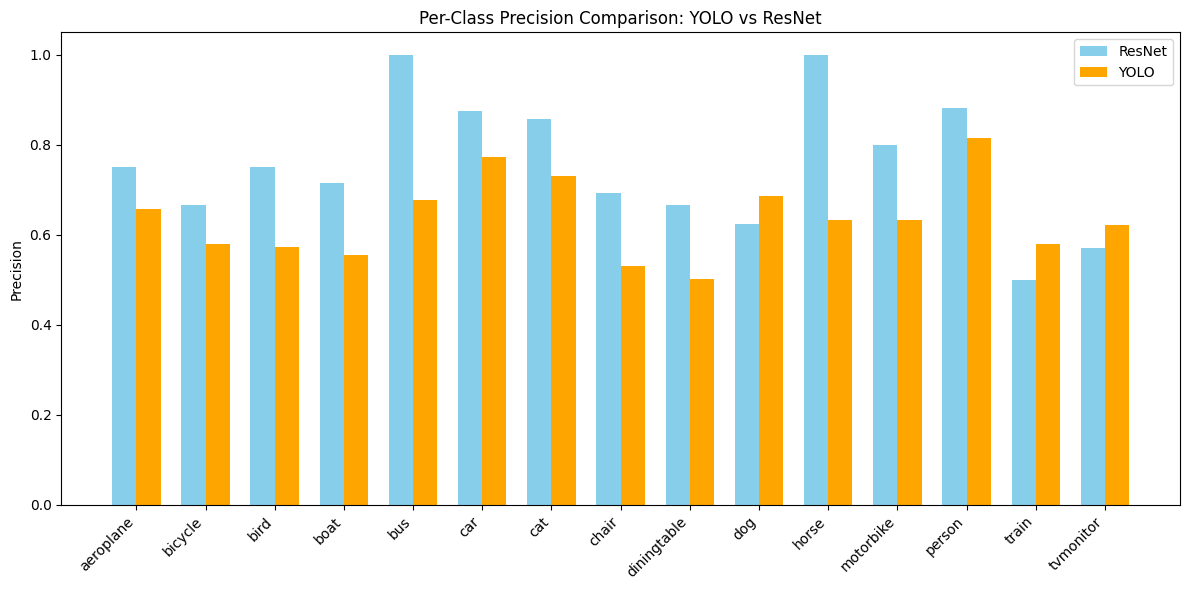

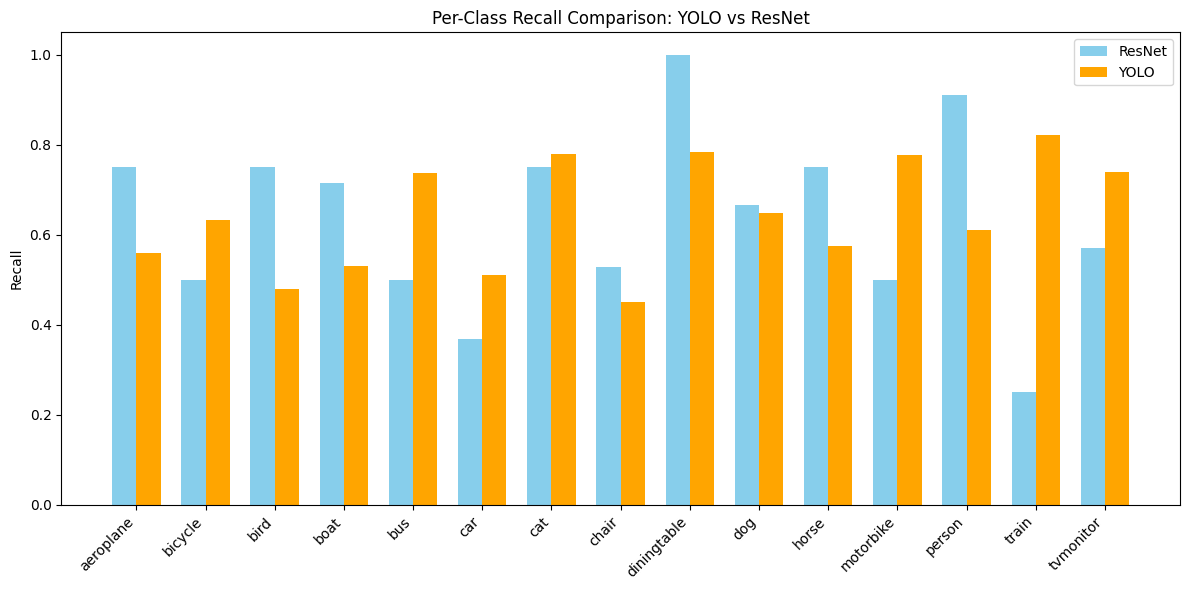

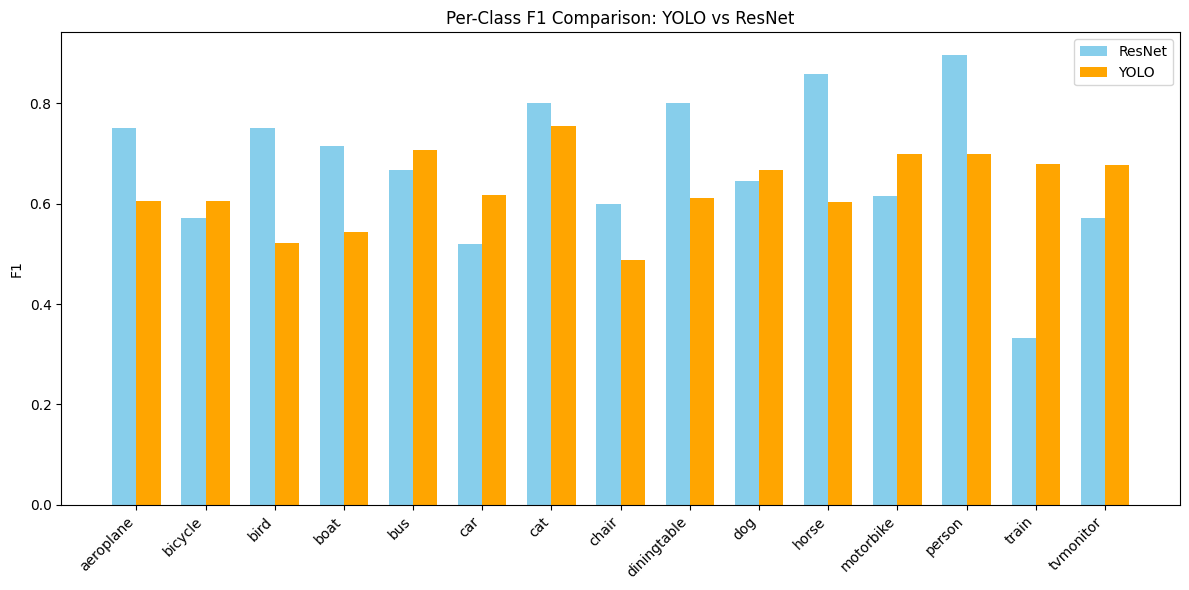

In [8]:
# --------------------------
# Function to create side-by-side bar charts
# --------------------------
def plot_metric_comparison(df_resnet, df_yolo, metric, save_path=None):
    x = np.arange(len(df_resnet))  # positions for classes
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width/2, df_resnet[metric], width, label='ResNet', color='skyblue')
    ax.bar(x + width/2, df_yolo[metric], width, label='YOLO', color='orange')
    
    ax.set_xticks(x)
    ax.set_xticklabels(df_resnet['class'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'Per-Class {metric} Comparison: YOLO vs ResNet')
    ax.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# --------------------------
# Generate bar charts for Precision, Recall, F1
# --------------------------
plot_metric_comparison(df_resnet, df_yolo, "Precision", os.path.join(comparison_results_dir, "comparison_precision.png"))
plot_metric_comparison(df_resnet, df_yolo, "Recall", os.path.join(comparison_results_dir, "comparison_recall.png"))
plot_metric_comparison(df_resnet, df_yolo, "F1", os.path.join(comparison_results_dir, "comparison_f1.png"))



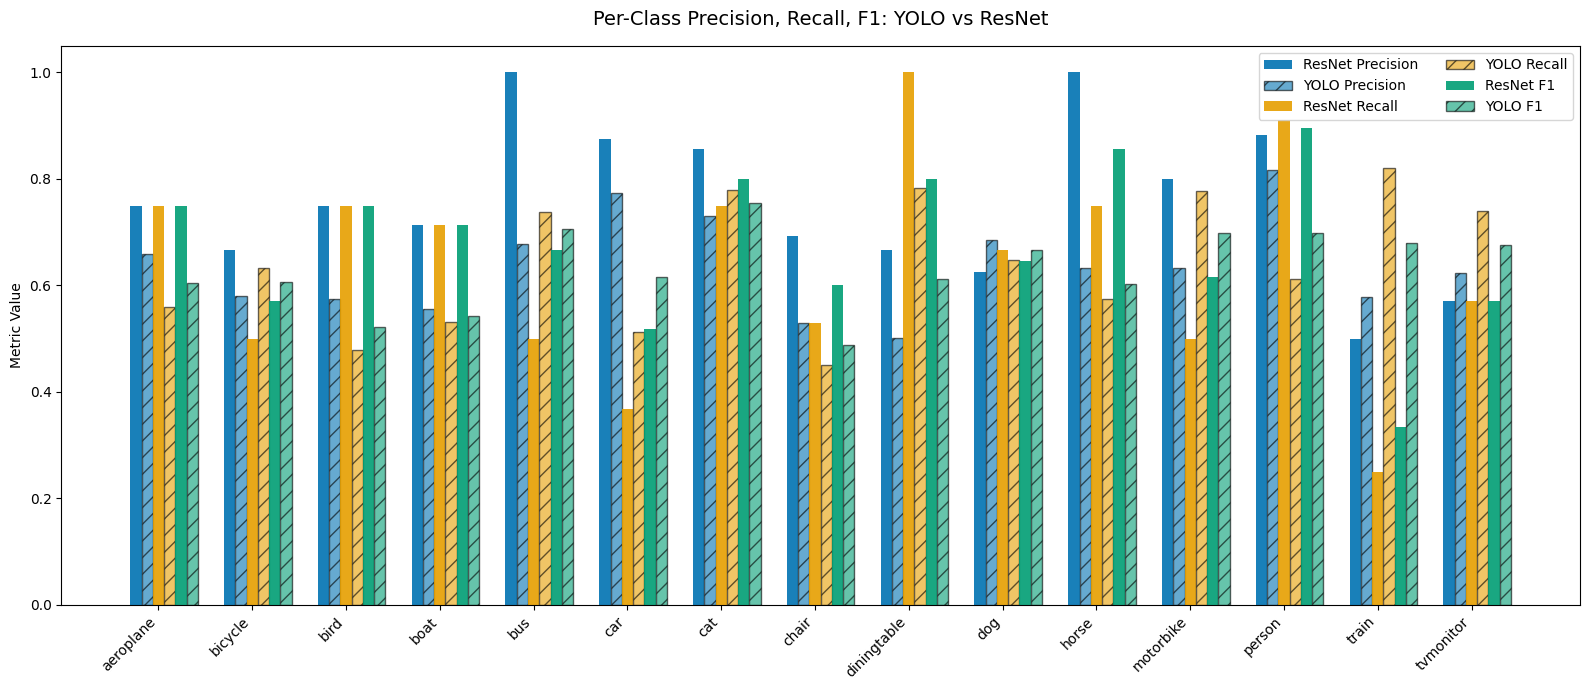

In [9]:
# --------------------------
# Grouped bar chart with 6 categories
# --------------------------


metrics = ['Precision', 'Recall', 'F1']
x = np.arange(len(df_resnet))
width = 0.12

fig, ax = plt.subplots(figsize=(16,7))

# Color-blind friendly palette (Okabe-Ito)
metric_colors = {
    'Precision': '#0072B2',  # blue
    'Recall': '#E69F00',     # orange
    'F1': '#009E73'          # green
}

handles = []
labels = []

for i, metric in enumerate(metrics):
    # ResNet
    bars_resnet = ax.bar(x + (i-1)*2*width, df_resnet[metric], width,
                         color=metric_colors[metric], alpha=0.9)
    handles.append(bars_resnet)
    labels.append(f"ResNet {metric}")

    # YOLO
    bars_yolo = ax.bar(x + (i-1)*2*width + width, df_yolo[metric], width,
                       color=metric_colors[metric], alpha=0.6, hatch='//', edgecolor='black')
    handles.append(bars_yolo)
    labels.append(f"YOLO {metric}")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(df_resnet['class'], rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Metric Value")
ax.set_ylim(0, 1.05)
ax.set_title("Per-Class Precision, Recall, F1: YOLO vs ResNet", fontsize=14, pad=15)

# Full legend
ax.legend(handles, labels, fontsize=10, loc='upper right', ncol=2)

plt.tight_layout()
plt.savefig(os.path.join(comparison_results_dir, "comparison_grouped_metrics_clean.png"), bbox_inches='tight')
plt.show()


Scatter plot saved to C:/Users/kamed/Desktop/argonne_K/object_detection_with_pascal_voc\results\comparison_results\precision_recall_scatter.png


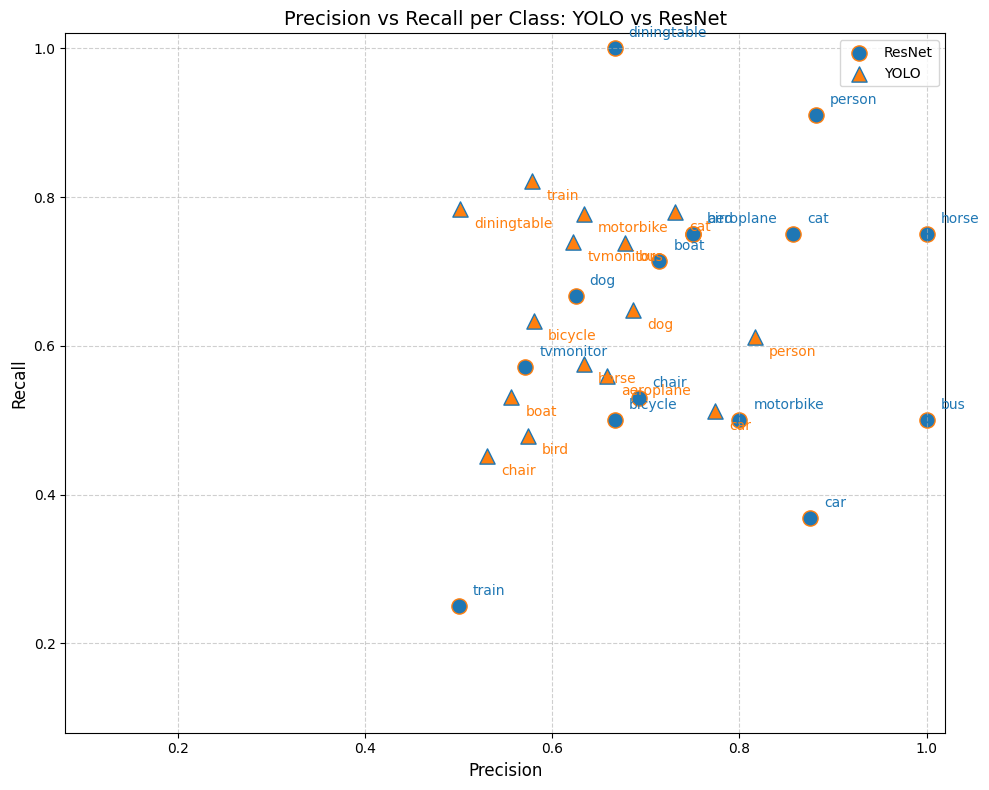

In [14]:
# --------------------------
# Scatter plot: Precision vs Recall
# --------------------------
plt.figure(figsize=(10, 8))

# ResNet points (blue circles with orange edge)
plt.scatter(df_resnet['Precision'], df_resnet['Recall'], 
            facecolors="#1f77b4", edgecolors="#ff7f0e", marker="o", s=120, label="ResNet")

# ResNet points (blue circles)
#plt.scatter(df_resnet['Precision'], df_resnet['Recall'], 
            #color="#CC3311", marker="o", s=100, label="ResNet")
# YOLO points (orange triangles with blue edge)
plt.scatter(df_yolo_precision['Precision'], df_yolo_recall['Recall'], 
            facecolors="#ff7f0e", edgecolors="#1f77b4", marker="^", s=120, label="YOLO")

# YOLO points (orange triangles)
#plt.scatter(df_yolo_precision['Precision'], df_yolo_recall['Recall'], 
            #color="#666666", marker="^", s=100, label="YOLO")
    
    # Add class labels with larger font
for i, cls in enumerate(df_resnet['class']):
    plt.text(df_resnet['Precision'][i] + 0.015, df_resnet['Recall'][i] + 0.015, cls,
             fontsize=10, color="#1f77b4")
    plt.text(df_yolo_precision['Precision'][i] + 0.015, df_yolo_recall['Recall'][i] - 0.025, cls,
             fontsize=10, color="#ff7f0e")

# Labels and formatting
plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.title("Precision vs Recall per Class: YOLO vs ResNet", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Set axis limits with small margins so points don't get cut off
plt.xlim(0.08, 1.02)
plt.ylim(0.08, 1.02)

plt.tight_layout()

# Save figure
save_path = os.path.join(comparison_results_dir, "precision_recall_scatter.png")
plt.savefig(save_path, bbox_inches="tight")

print(f"Scatter plot saved to {save_path}")
plt.show()